# Probabilistic Programming for Cosmology with JAX
<a target="_blank" href="https://colab.research.google.com/github/hsimonfroy/talks/blob/main/2024CoPhy/ppl4cosmo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%pip install -q numpyro getdist
%pip install -q git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples, gaussian_mixtures

from jax import numpy as jnp, random as jr, jit, grad, value_and_grad, hessian, vmap, tree, debug

import numpyro.distributions as dist
from numpyro import sample, deterministic, plate, infer, render_model
from numpyro.handlers import seed, condition, trace
from numpyro.infer.util import log_density


%matplotlib inline
%load_ext autoreload
%autoreload 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.6/826.6 kB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.1/351.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
0680513ed5dd
gpu


# Probabilistic Programming Language: introductory example

In [2]:
# To fully define a probabilistic model, we need
# 1. to define its simulator
def simulate(seed):
    rng = np.random.RandomState(seed)
    x = rng.randn()
    y = rng.randn() + x**2
    return y

print(simulate(seed=42))

# 2. to define its associated log joint density
from scipy.stats import norm
log_prior = lambda x: norm.logpdf(x, loc=0, scale=1)
log_lik = lambda x, y: norm.logpdf(y, loc=x**2, scale=1)
log_joint= lambda x, y: log_lik(y, x) + log_prior(x)

# 3. possibly, define its gradients, or its Hessian, or other derived functionals...
grad_log_prior = lambda x: x**2
grad_log_lik = lambda x, y: np.stack([2 * x * (y - x**2), (y - x**2)])
grad_log_joint = lambda x, y: grad_log_lik(y, x) + np.stack([grad_log_prior(x), np.zeros_like(y)])
# Hessian left as an exercise...

# 4. Ideally, we would like to easily invert the model, i.e. condition on some variables and infer the others
# This is often done with the help of external MCMC samplers packages

0.1084606486304816


To fully define a probabilistic model, we need
1. to define its simulator
2. to define its associated log joint density
3. possibly, define its gradients, or its Hessian, or other derived functionals...
4. Ideally, we would like to easily invert and simplify the model, i.e. condition and marginalize on some variables and infer the others.

> What if we could only do step 1.?

This is the goal of a **Probabilistic Programming Language (PPL)**.

There exists several PPLs: Stan, PyMC, NumPyro...

One main advantage of NumPyro is to be powered by JAX, benefiting directly from:
* GPU acceleration
* JIT compilation
* vectorization/parallelization
* automatic differentiation

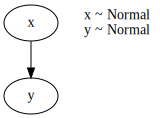

In [3]:
from numpyro import sample, deterministic, plate, render_model

def model():
    x = sample('x', dist.Normal(0, 1))

    ###############
    # TODO: sample y from a Normal distribution with mean x**2 and std 1
    y = sample('y', dist.Normal(x**2, 1))
    # y =
    ###############

    return y

render_model(model, render_distributions=True)

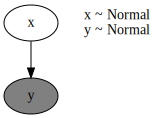

In [4]:
from numpyro.handlers import seed, condition, trace

# Handle random seeds for reproducibility
seeded_model = seed(model, 42)

# Sample from model
y_obs = dict(y=seeded_model())

# Condition model on variable
obs_model = condition(model, y_obs)
render_model(obs_model, render_distributions=True)

In [5]:
from numpyro.infer.util import log_density

# Compute log probability of model
log_joint = lambda params: log_density(model,(),{},params)[0]
print(log_joint({'x': 0., 'y': 0.}))

-1.837877


In [6]:
vlim = -3,3
n_discr = 100
xs, ys = jnp.linspace(*vlim, n_discr), jnp.linspace(*vlim, n_discr)
xx, yy = jnp.meshgrid(xs, ys)
xy = {'x': xx, 'y': yy}
logps = vmap(vmap(log_joint))(xy)

###################
# TODO: compute the force field associated to the log joint.
# Don't forget xx and yy are 2D arrays, you will need to vectorize
forces = vmap(vmap(grad(log_joint)))(xy)
# forces =
###################

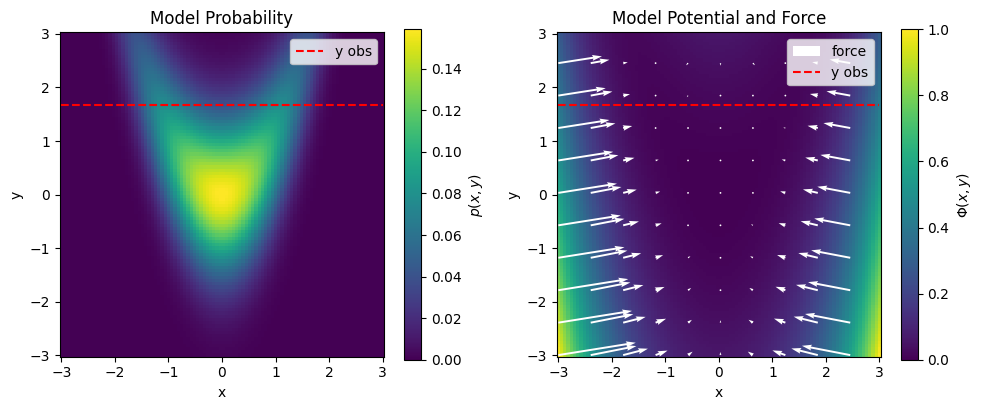

In [7]:
# @title Plot model probability, potential, and force fields
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.pcolormesh(xy['x'], xy['y'], jnp.exp(logps), cmap='viridis')
plt.hlines(y_obs['y'], *vlim, color='r', linestyle='--', label='y obs')
plt.colorbar(label='$p(x,y)$'), plt.gca().set_aspect(1)
plt.xlabel('x'), plt.ylabel('y')
plt.title('Model Probability')
plt.legend()

plt.subplot(122)
plt.pcolormesh(xy['x'], xy['y'], -logps, cmap='viridis')
step = 10
plt.quiver(xy['x'][::step,::step], xy['y'][::step,::step],
           forces['x'][::step,::step], forces['y'][::step,::step],
           color='white', label='force')
plt.hlines(y_obs['y'], *vlim, color='r', linestyle='--', label='y obs')
plt.colorbar(label='$\\Phi(x,y)$'), plt.gca().set_aspect(1)
plt.xlabel('x'), plt.ylabel('y')
plt.title('Model Potential and Force')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
kernel = infer.NUTS(obs_model)
mcmc = infer.MCMC(kernel, num_warmup=100, num_samples=1000, num_chains=8, chain_method='vectorized')
mcmc.run(jr.key(42))
samples = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 1100/1100 [00:14<00:00, 76.69it/s] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.02      0.99      0.04     -1.43      1.50    874.96      1.01

Number of divergences: 216


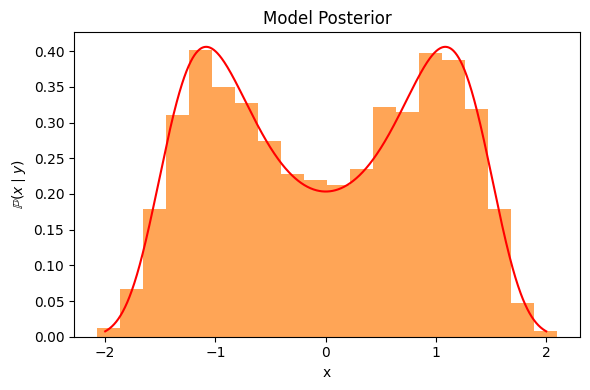

In [9]:
# @title Plot posterior samples
plt.figure(figsize=(6,4))
xs = jnp.linspace(-2,2,1000)
logp_fn = lambda x: log_density(obs_model,(),{},dict(x=x))[0]
logps = jnp.exp(vmap(logp_fn)(xs))
logposts = logps / np.trapz(logps, xs)
plt.plot(xs, logposts, color='red')
plt.hist(samples['x'], density=True, color='tab:orange', alpha=0.7, bins=20)
plt.xlabel('x'), plt.ylabel('$\\mathbb{P}(x \\mid y)$')
plt.title('Model Posterior')
plt.tight_layout()

# Power spectrum model

## Model
To handle cosmology and compute power spectrum, we will use [JaxCosmo](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) from the *Differentiable Universe Initiative*.

Here `linear_matter_power` uses Eisenstein & Hu matter transfer function approximation ([Einsenstein and Hu, 1998](https://ui.adsabs.harvard.edu/abs/1998ApJ...496..605E/abstract)).

For a (differentiable) Einstein-Boltzmann solver in JAX, see [DISCO-DJ](https://github.com/ohahn/DISCO-EB).

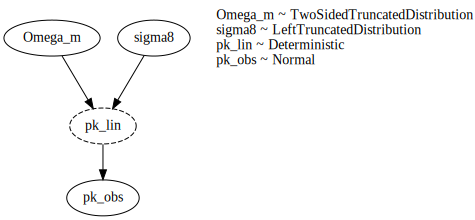

In [10]:
# @title Define a simple power spectrum model
from jax import config
config.update('jax_enable_x64', True)
import jax_cosmo as jc


def get_cosmology(Omega_m, sigma8):
    return jc.Planck15(Omega_c=Omega_m - jc.Planck15.keywords['Omega_b'], sigma8=sigma8)


def linear_pk_interp(cosmology, a=1., n_interp=128):
    """
    Return a light emulation of the linear matter power spectrum.
    """
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmology, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
    return pk_fn


def prior_model():
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.31, 0.2, low=jc.Planck15.keywords['Omega_b'], high=1.))
    sigma8 = sample('sigma8', dist.TruncatedNormal(0.81, 0.2, low=0.))
    return dict(Omega_m=Omega_m, sigma8=sigma8)


def lik_model(Omega_m, sigma8, z, ks):
    cosmology = get_cosmology(Omega_m, sigma8)
    pk_fn = linear_pk_interp(cosmology, a=1/(1+z))
    pk_lin = deterministic('pk_lin', pk_fn(ks))
    # Shot noise std is approximately proportional to 1/k
    pk_obs = sample('pk_obs', dist.Normal(pk_lin, 30/ks))
    return pk_obs


def model(z, ks):
    params = prior_model()
    return lik_model(**params, z=z, ks=ks)

# Model configuration
config = {'z': 1.,
          'ks': jnp.linspace(10e-3, 0.5, 50),}

# Names and labels for plots
names = ["Omega_m", "sigma8"]
labels = ["\\Omega_m", "\\sigma_8"]

model = partial(model, **config)
render_model(model, render_distributions=True)

The model defines a joint distributions over variables, i.e. it defines the random variable $\Omega_m, \sigma_8, P_\text{obs}$.

The distribution of observed $P_\text{obs}$ is sometimes called the **evidence** or the **prior predictive distribution**, because it is the distribution predicted by the prior on $\Omega_m, \sigma_8$. Let's sample from it.

In [33]:
# Sample 10 000 realizations from the unconditionned model, i.e. the prior predictive distribution
prior_preds = infer.Predictive(model, num_samples=10_000, parallel=True)(jr.PRNGKey(43))

# infer.Predictive is a wrapper around the trace handler:
# trace(seed(model, 43)).get_trace()

Before plotting it, let us also assume a true cosmology $\Omega^0 := \Omega_m^0, \sigma_8^0$ and generate a corresponding realization $\Omega_m^0, \sigma_8^0, P_\text{obs}^0$. We will define it as the true realization.

In [31]:
# Let us set a true cosmology and generate a corresponding realization
true_cosmo = {'Omega_m': 0.3, 'sigma8': 0.8}

##################
# TODO: sample 1 realization from the true cosmology
true_real = infer.Predictive(model, params=true_cosmo, num_samples=1, parallel=True)(jr.PRNGKey(44))
# true_real =
##################

print(true_real.keys())

dict_keys(['Omega_m', 'pk_lin', 'pk_obs', 'sigma8'])


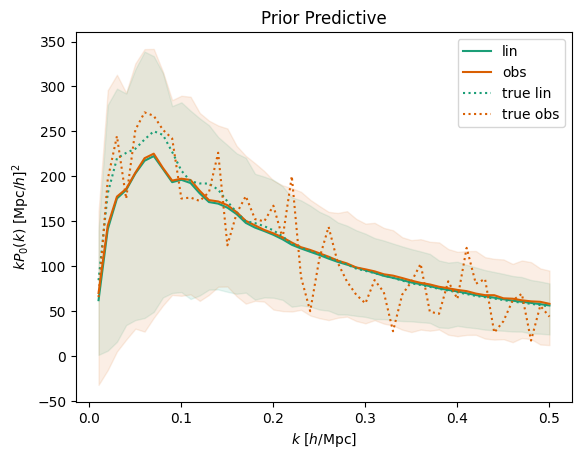

In [13]:
# @title Plot prior predictive realizations
def hdi(x, proba=.95, axis=0):
    """
    Compute the Highest Density Interval (HDI),
    i.e. the smallest interval of proba `proba`.
    """
    x = np.moveaxis(x, axis, 0)
    x_sort = jnp.sort(x, axis=0)
    n = x.shape[0]
    # Round for better estimation at low number of sample, and handle also the case proba close to 1.
    i_length = min(int(jnp.rint(proba * n)), n-1)

    intervals_low = x_sort[: (n - i_length)] # no need to consider all low bounds
    intervals_high = x_sort[i_length:]  # no need to consider all high bounds
    intervals_length = intervals_high - intervals_low # all intervals with given proba
    i_low = intervals_length.argmin(axis=0)
    i_high = i_low + i_length
    hdi_low = jnp.take_along_axis(x_sort, i_low[None], 0)[0]
    hdi_high = jnp.take_along_axis(x_sort, i_high[None], 0)[0]
    return jnp.stack([hdi_low, hdi_high], axis=axis)

cmap = plt.get_cmap('Dark2')
def plot_pks(pks, *args, c, **kwargs):
    plot_pk = lambda pk, *args, **kwargs: plt.plot(ks, ks*pk, *args, **kwargs)
    ks = config['ks']
    plot_pk(jnp.median(pks, 0), *args, c=c, **kwargs)
    if len(pks) > 1:
        plt.fill_between(ks, *hdi(pks, 0.68)*ks, color=c, alpha=0.1)
    plt.xlabel("$k$ [$h$/Mpc]"), plt.ylabel(f"$k P_{0}(k)$ [Mpc/$h$]$^2$")

plot_pks(prior_preds['pk_lin'], c=cmap(0), label='lin')
plot_pks(prior_preds['pk_obs'], c=cmap(1), label='obs')
plot_pks(true_real['pk_lin'], ':', c=cmap(0), label='true lin')
plot_pks(true_real['pk_obs'], ':', c=cmap(1), label='true obs')
plt.title('Prior Predictive')
plt.legend(), plt.show();

## Fisher forecast

We want to compute the **Cramér-Rao bound at a fiducial cosmology**. For any estimator $\hat \theta$ such that $\mathbb E[\hat \theta(x) \mid \theta]= \theta$, we have
<!-- $$\mathbb E[(\hat \theta(x) - \theta)(\hat \theta(x) - \theta)^\top \mid \theta] \succeq I^{-1}(\theta)$$ -->
$$\operatorname{\mathbb C\!ov}[\hat \theta(x) \mid \theta] \succeq I[\theta]^{-1}$$
where $$I[\theta] := \mathbb E[\nabla^2_\theta \Phi(x \mid \theta) \mid \theta]\quad ; \quad \Phi(x \mid \theta) := -\log p(x \mid \theta)$$
In our case, we compute $$ \hat I[\Omega^0] := \frac{1}{n}\sum_{i=1}^n \nabla^2_{\Omega^0} \Phi(P_\text{obs}^i \mid \Omega^0), \quad (P_\text{obs}^i)_{i=1}^n \overset{\perp\!\!\!\perp}{\sim} P_\text{obs} \mid \Omega_0$$
Such that $\hat I[\Omega^0] \simeq I[\Omega^0]$

In [14]:
def fisher_fn(fiduc_cosmo, lik_model, num_samples, **config):
    # Sample from fiducial cosmology
    lik_model = partial(lik_model, **fiduc_cosmo, **config)
    fiduc_preds = infer.Predictive(lik_model, num_samples=num_samples, parallel=True)(jr.PRNGKey(45))

    # Compute Hessians
    potential = lambda cosmo, obs: -log_density(lik_model, (), cosmo, obs)[0]

    #############
    # TODO: Compute the Hessian function of the potential (with respect to cosmology)
    hessian_fn = hessian(potential)
    # hessian_fn =
    #############

    hessians_fn = vmap(lambda obs: hessian_fn(fiduc_cosmo, obs))
    hessians = hessians_fn({'pk_obs': fiduc_preds['pk_obs']})

    # Compute Fisher matrix
    fisher = tree.map(lambda x: x.mean(0), hessians)
    fisher_matrix = jnp.array([[fisher[k1][k2] for k1 in fisher] for k2 in fisher])

    # Return mean and covariance
    cov = jnp.linalg.inv(fisher_matrix)
    mean = jnp.array([fiduc_cosmo[k] for k in fiduc_cosmo])
    return mean, cov

In [15]:
fisher_fn = jit(partial(fisher_fn, lik_model=lik_model, num_samples=100, **config))
mean, cov = fisher_fn(true_cosmo)

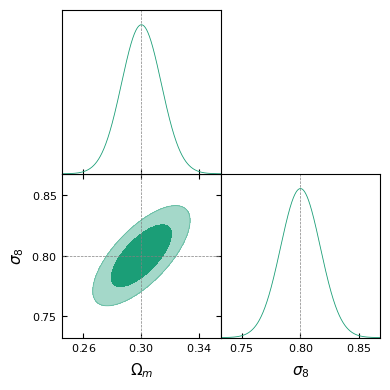

In [16]:
# @title Plot Fisher forecast
gd_fisher = gaussian_mixtures.GaussianND(mean, cov, names=names, labels=labels, label='Fisher')
g = plots.get_subplot_plotter()
g.triangle_plot(gd_fisher, filled=True, contour_colors=[cmap(0)], markers=true_cosmo)

## Posterior

Fisher forecast is a forecast. It talks about optimal variance of unbiased estimators, **at a fiducial point**. It does not depend on observations.

Now we have an observation $P_\text{obs}^0$, so we want the posterior $\Omega \mid P_\text{obs}^0$ and its associated quantities (mean, std, quantiles, highest density regions...)

We start by conditioning the model by $P_\text{obs}^0$, i.e. we fix $P_\text{obs} = P_\text{obs}^0$, which flags it as observed.

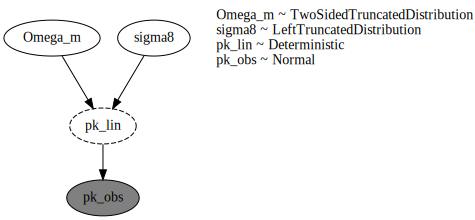

In [17]:
# Condition model on observation
obs_model = condition(model, {'pk_obs': true_real['pk_obs']})
render_model(obs_model, render_distributions=True)

Now we need to sample from this new model. This is not an easy task!

Bayesian inversion is equivalent to computing integrals. But formal integration is in general undecidable (Richardson theorem), and numerical integration is inevitably limited by the evaluation/sampling cost and by the integrand roughness and dimensionality (e.g. [Novak, 2014](http://arxiv.org/abs/1409.6714)).

Nevertheless, if we are ready to pay the numerical cost, some methods can cleverly leverage integrand properties such as differentiability.

### Basic MCMC: Metropolis-Hastings
[demo](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana)

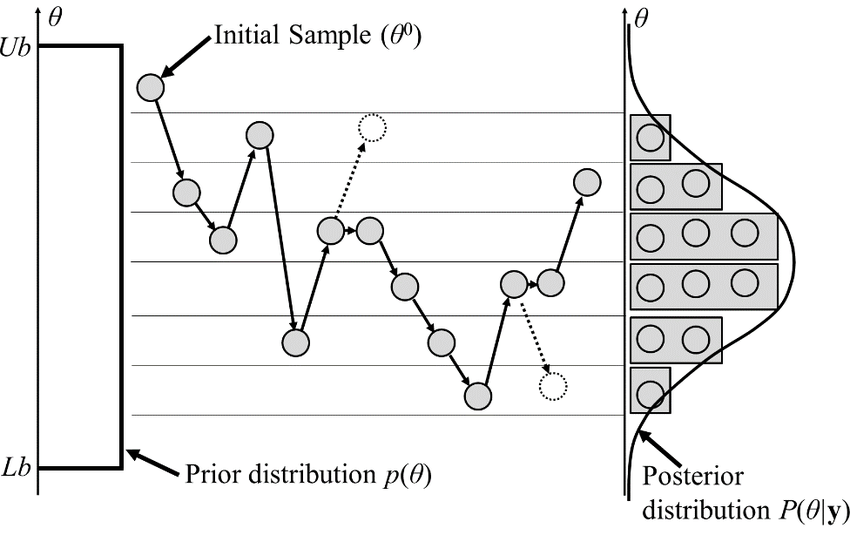

### Gradient based MCMC: Hamiltonian Monte Carlo

* To travel farther, add inertia.
    * sample particle at position $q$ now have momentum $p$ and mass matrix $M$
    * target $\boldsymbol{p}(q)$ becomes $\boldsymbol{p}(q , p) := e^{-\mathcal H(q,p)}$, with Hamiltonian $$\mathcal H(q,p) := \Phi(q) + K(p) = -\log \boldsymbol{p}(q) + \frac 1 2 p^\top M^{-1} p$$
    * at each step, resample momentum $p \sim \mathcal N(0,M)$
    * let $(q,p)$ follow the Hamiltonian dynamic during time length $L$, $$\dot q = \partial_p H \quad;\quad \dot p = -\partial_q H$$then arrival becomes new MH proposal.
* Way less correlated than MH, cf. [demo](https://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html)
$ $

In [18]:
# Sample from posterior
# No need to jit, NumPyro will do it for us.
kernel = infer.NUTS(obs_model, init_strategy=infer.init_to_sample())
mcmc = infer.MCMC(kernel, num_warmup=100, num_samples=400, num_chains=4, chain_method='vectorized')
mcmc.run(jr.key(43), extra_fields=['num_steps'])

samples, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("n_evals:", extra['num_steps'].sum())
mcmc.print_summary()

sample: 100%|██████████| 500/500 [02:09<00:00,  3.87it/s]


n_evals: 9024

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.29      0.01      0.29      0.27      0.31    643.66      1.00
    sigma8      0.79      0.02      0.79      0.76      0.81    651.78      1.00

Number of divergences: 0


In [ ]:
# @title Alternative samplers
from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA, RandomWalkMetropolis as MH

# Choose an alternative sampler (usually less efficients)
sampler = "MALA"

if sampler == "MALA":
    kernel = MALA(model=obs_model, init_strategy=infer.init_to_sample(), step_size=1e-4)
elif sampler == "MH":
    def new_state_fn(state, key):
        diffus = [dist.Normal(jnp.zeros(len(state)), 0.1*jnp.ones(len(state))).sample(key)]
        return tree.map(lambda x,y:x+y, state, diffus)
    kernel = MH(model=obs_model, new_state_fn=new_state_fn, init_strategy=infer.init_to_sample())

# Sample from posterior
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=10_000)
mcmc.run(jr.key(43))
samples_brw = mcmc.get_samples()
mcmc.print_summary()

2024-11-18 16:19:59.101766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


sample: 100%|██████████| 11000/11000 [02:36<00:00, 70.51it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.32      0.01      0.32      0.30      0.34     68.33      1.06
    sigma8      0.82      0.02      0.82      0.80      0.85    138.20      1.02



Removed no burn in


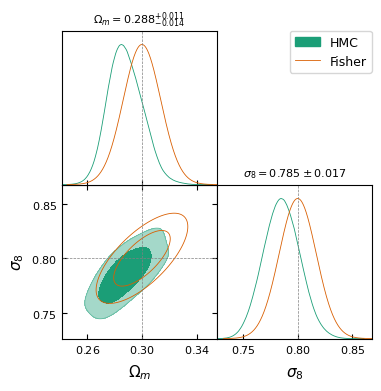

In [19]:
# @title Plot posteriors
def get_gdsamples(samples, names, labels, label):
    return MCSamples(samples=[samples[k] for k in names], names=names, labels=labels, label=label)

roots = []
roots.append(get_gdsamples(samples, names, labels, 'HMC'))
roots.append(gd_fisher)
# roots.append(get_gdsamples(samples_brw, names, labels, 'LMC'))
# roots.append(get_gdsamples(prior_preds, names, labels, 'Prior'))

g = plots.get_subplot_plotter()
g.triangle_plot(roots=roots,
                title_limit=1,
                filled=[True, False],
                contour_colors=[cmap(i) for i in range(len(roots))],
                markers=true_cosmo)

In [41]:
##################
# TODO: sample realizations from the conditionned model, i.e. the posterior predictive distribution
post_preds = infer.Predictive(model, samples, parallel=True)(jr.PRNGKey(43))
# post_preds =
##################

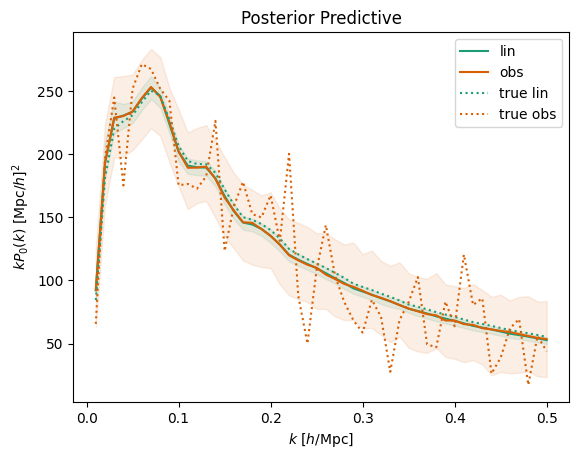

In [43]:
# @title Plot posterior predictive realizations
plot_pks(post_preds['pk_lin'], c=cmap(0), label='lin')
plot_pks(post_preds['pk_obs'], c=cmap(1), label='obs')
plot_pks(true_real['pk_lin'], ':', c=cmap(0), label='true lin')
plot_pks(true_real['pk_obs'], ':', c=cmap(1), label='true obs')
plt.title('Posterior Predictive')
plt.legend(), plt.show();

# N-body model

## N-body with JaxPM

In [46]:
# @title Define plotting utils
from PIL import Image
def load_image(im_path, size=None, bg='WHITE'):
    img = Image.open(im_path).convert('RGBA')
    white_bg = Image.new('RGBA', img.size, bg)
    img = Image.alpha_composite(white_bg, img).convert('L')

    if size is not None:
        img = img.resize(size)
    return np.array(img)

def load_mesh(im_path, depth, size=None, bg='WHITE'):
    img = load_image(im_path, size, bg)
    display(img)
    mesh = jnp.broadcast_to(img[::-1].T[...,None], (*img.shape, depth))
    print(f"{mesh.shape=}")
    return (1 - mesh.astype(jnp.float32) / 255) * 10

from matplotlib import animation, rc
rc('animation', html='html5')

def plot_mesh(meshes, i, vlim, cmap="binary", **config):
    mesh_shape, box_shape = config['mesh_shape'], config['box_shape']
    xx, yy = jnp.indices(mesh_shape[:2]) * (box_shape/mesh_shape)[:2,None,None]
    vmin, vmax = vlim

    quad = plt.pcolormesh(xx, yy, meshes[i].mean(-1), vmin=vmin, vmax=vmax, cmap=cmap)
    plt.xlabel("$x$ [Mpc/$h$]"), plt.ylabel("$y$ [Mpc/$h$]")
    plt.gca().set_aspect(1)
    return quad

def plot_meshes(meshes, titles=None, joint_scale=False, cmap="binary", **config):
    meshes = jnp.asarray(meshes)
    if joint_scale:
        vlim = jnp.quantile(meshes, 0.01), jnp.quantile(meshes, 0.99)
    else:
        vlim = None,None

    plt.figure(figsize=(6*len(meshes), 6))
    for i_mesh, mesh in enumerate(meshes):
        plt.subplot(1, len(meshes), i_mesh+1)
        plot_mesh(meshes, i_mesh, vlim, cmap, **config)

        if titles is not None:
            plt.title(titles[i_mesh])
        if not joint_scale:
            plt.colorbar()
    plt.tight_layout()

def animate_meshes(meshes, cmap="binary", **config):
    meshes = jnp.asarray(meshes)
    vlim = jnp.quantile(meshes, 0.01), jnp.quantile(meshes, 0.99)
    quad = plot_mesh(meshes, 0, vlim, cmap, **config)
    plt.colorbar()

    def update(i):
        if i < len(meshes):
            quad.set_array(meshes[i].mean(-1))
        return quad,

    anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes)+10, interval=100, blit=True)
    plt.close()
    display(anim)

Galaxy surveys build 3D maps of the universe by measuring galaxy redshifts. From such galaxy catalogs, we can observe the Baryonic Acoustic Oscillations (BAO), a manifestation of the evolved primordial fluctuations...

Wait actually, it is not the BAO, it is BaoBan, the wild coyote and DESI embassador!

How is it possible that the matter primordial fluctuations collapsed into this capricious face?

**Could we reconstruct its initial conditions?**

File ‘BaoBan.png’ already there; not retrieving.



array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
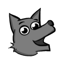

mesh.shape=(64, 64, 4)


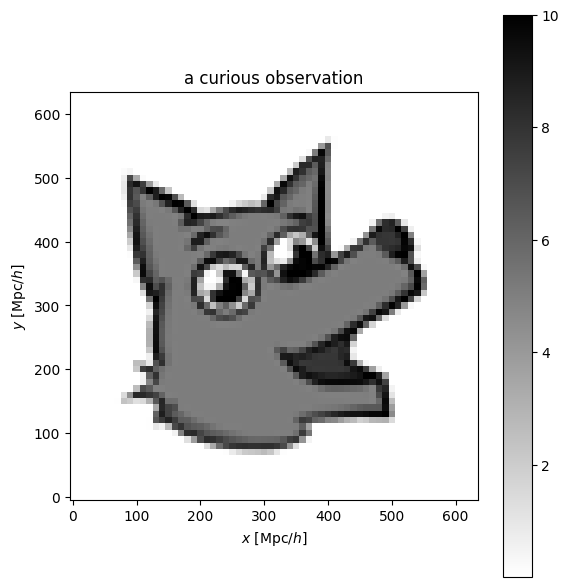

In [61]:
!wget -nc https://raw.githubusercontent.com/hsimonfroy/talks/main/2024CoPhy/BaoBan.png
im_path = "./BaoBan.png"
obs_mesh = load_mesh(im_path, depth=4, size=(64,64))

config = {
    'mesh_shape': obs_mesh.shape,
    'box_shape': np.array(obs_mesh.shape) * 10, # in Mpc/h
    'a_lpt': 0.1,
    'a_obs': 1.,
    'std_obs': 1.,
    'n_snapshots': 30,
}

plot_meshes([obs_mesh], ["a curious observation"], **config)

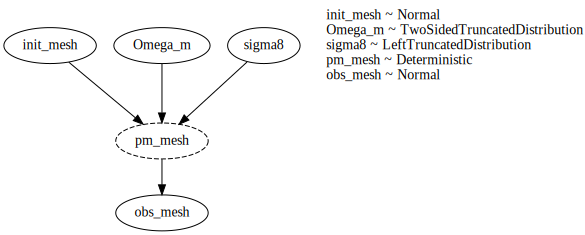

In [62]:
# @title Define a simple matter density field model
import jax_cosmo as jc
from jaxpm.painting import cic_paint
from jaxpm.pm import lpt, make_ode_fn
from jaxpm.kernels import fftk
from jax.experimental.ode import odeint

def get_cosmology(Omega_m, sigma8):
    return jc.Planck15(Omega_c=Omega_m - jc.Planck15.keywords['Omega_b'], sigma8=sigma8)


def linear_pk_interp(cosmology, a=1., n_interp=128):
    """
    Return a light emulation of the linear matter power spectrum.
    """
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmology, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
    return pk_fn


def get_init_mesh(init_mesh_, cosmology,
                  mesh_shape, box_shape, **config):
    """
    Return initial conditions at a=1 from latent params.
    """
    # Compute initial power spectrum
    pk_fn = linear_pk_interp(cosmology)
    kvec = fftk(mesh_shape)
    k_box = sum((ki  * (m / l))**2 for ki, m, l in zip(kvec, mesh_shape, box_shape))**0.5
    pk_mesh = pk_fn(k_box) * (mesh_shape / box_shape).prod() # NOTE: convert from (Mpc/h)^3 to cell units

    # Apply transfer function
    delta_k = jnp.fft.rfftn(init_mesh_)
    delta_k *= pk_mesh**0.5
    init_mesh = jnp.fft.irfftn(delta_k)
    return init_mesh


def nbody(init_mesh, cosmology,
          mesh_shape, a_lpt, a_obs, n_snapshots, **config):
    """
    Compute matter field at a_lpt then evolve it to a_obs.
    """
    # Initial displacement
    pos = jnp.indices(mesh_shape).reshape(3,-1).T
    cosmology._workspace = {}
    dx, p, f = lpt(cosmology, init_mesh, pos, a_lpt)

    # Evolve the simulation forward
    snapshots = jnp.linspace(a_lpt, a_obs, n_snapshots)
    pos, p = odeint(make_ode_fn(mesh_shape), [pos+dx, p], snapshots, cosmology, rtol=1e-3, atol=1e-3)
    return jnp.stack([cic_paint(jnp.zeros(mesh_shape), pos_i) for pos_i in pos])


def mean_model(init_mesh, Omega_m, sigma8, **config):
    cosmology = get_cosmology(Omega_m, sigma8)
    init_mesh = get_init_mesh(init_mesh, cosmology, **config) ###
    meshes = nbody(init_mesh, cosmology, **config)
    return meshes


def prior_model(mesh_shape, **config):
    init_mesh = sample('init_mesh', dist.Normal(0, 1).expand(mesh_shape))
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.31, 0.5, low=jc.Planck15.keywords['Omega_b'], high=1.))
    sigma8 = sample('sigma8', dist.TruncatedNormal(0.81, 0.5, low=0.))
    params = dict(init_mesh = init_mesh,
                  Omega_m = Omega_m,
                  sigma8 = sigma8,)
    return params


def lik_model(params, std_obs, **config):
    pm_mesh = mean_model(**params, **config | dict(n_snapshots=2))[-1]
    pm_mesh = deterministic('pm_mesh', pm_mesh)
    return sample('obs_mesh', dist.Normal(pm_mesh, std_obs))


def model(**config):
    params = prior_model(**config)
    return lik_model(params, **config)


model = partial(model, **config)
render_model(model, render_distributions=True, render_params=True)

Thanks to [JaxPM](https://github.com/DifferentiableUniverseInitiative/JaxPM/) from the *Differentiable Universe Initiative*, we can build fast and differentiable N-body simulators. [Multi-GPU version](https://github.com/DifferentiableUniverseInitiative/JaxPM/tree/ASKabalan/jaxdecomp_proto) coming soon.

We can then condition on cosmology, meshes, particles positions and velocities, etc. and compute many model log density and derivatives.

In the following, we condition on both observed mesh and cosmology, but one could also relax cosmology and optimize or sample from it.

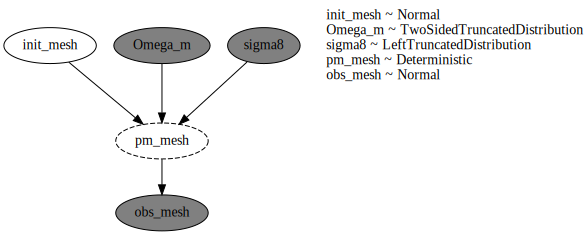

In [76]:
params = dict(init_mesh = jr.normal(jr.key(0), config['mesh_shape']),)
obs = dict(obs_mesh=obs_mesh)
cosmo = dict(Omega_m=0.31, sigma8=0.81)
obs |= cosmo

obs_model = condition(model, obs)
render_model(obs_model, render_distributions=True, render_params=True)

## Posterior mode

In [77]:
potential_fn = lambda params: -log_density(obs_model, (), {}, params)[0]
###################
# TODO: Compute the potential value and gradient function, and jit it
potential_valgrad_fn = jit(value_and_grad(potential_fn))
# potential_valgrad_fn =
###################

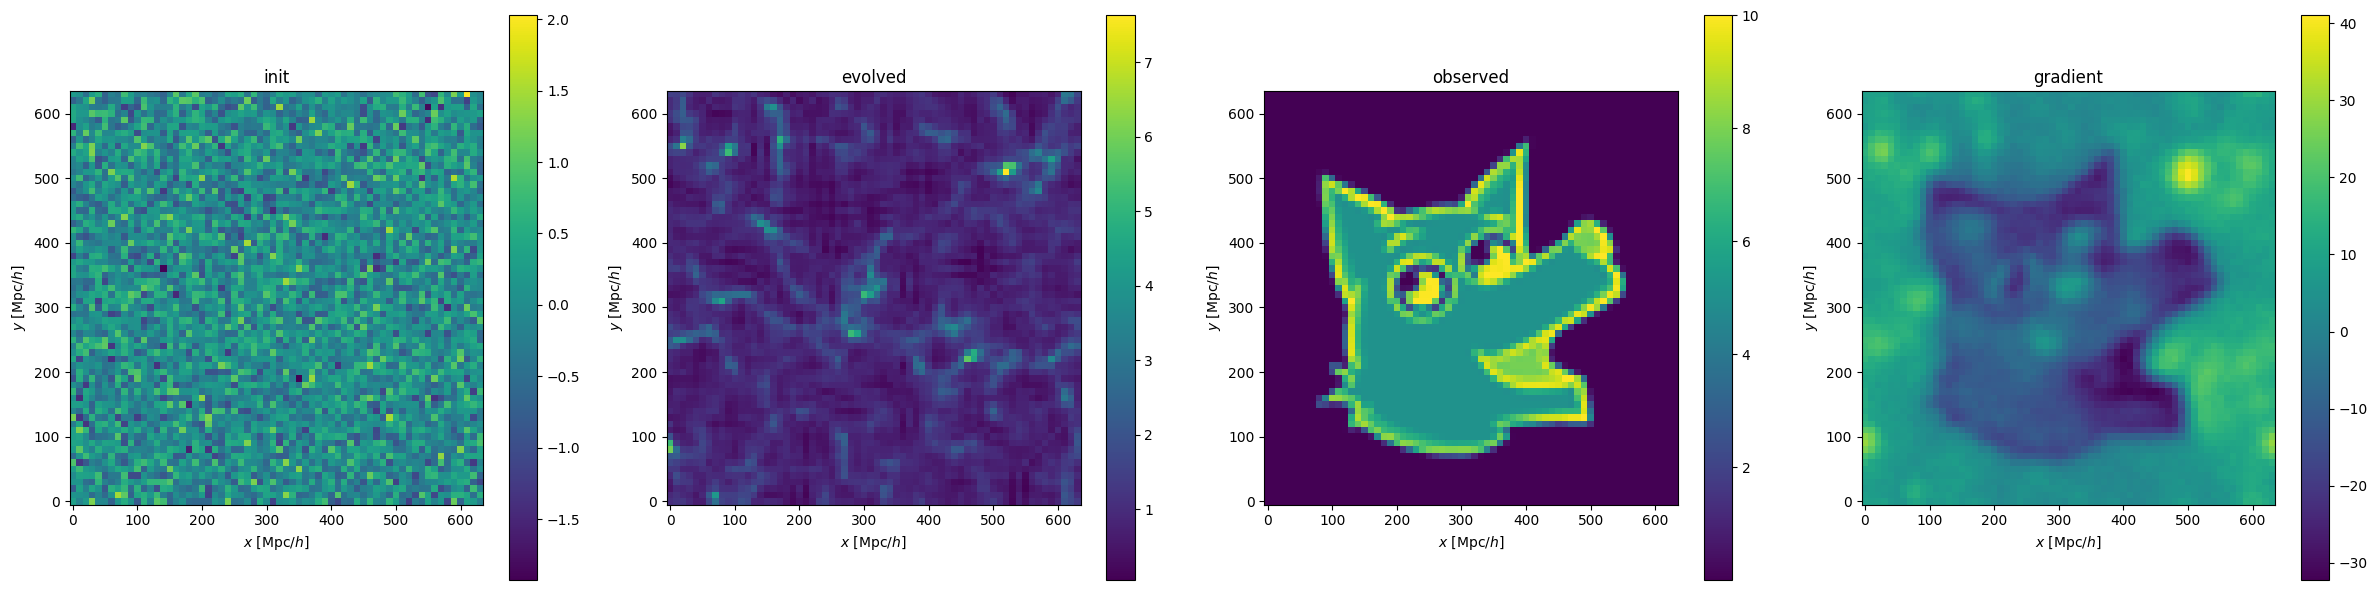

In [79]:
# @title Plot the initial optimization state
get_pm_meshes = partial(mean_model, **cosmo, **config)
def plot_optim_state(params):
    pm_meshes = get_pm_meshes(**params)
    animate_meshes(pm_meshes, **config)
    # plot_meshes(meshes, joint_scale=True, **config)

    meshes = jnp.stack([params['init_mesh'], pm_meshes[-1], obs_mesh, potential_valgrad_fn(params)[1]['init_mesh']])
    titles = ['init', 'evolved', 'observed', 'gradient']
    plot_meshes(meshes, titles, cmap='viridis', **config)
    return pm_meshes[-1]

pm_mesh = plot_optim_state(params)

In [53]:
# Let us use a simple Adam optimizer
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = .1
n_epochs = 300
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params)

def step(step, opt_state):
    value, grads = potential_valgrad_fn(get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params = get_params(opt_state)

100%|██████████| 300/300 [00:54<00:00,  5.53it/s]


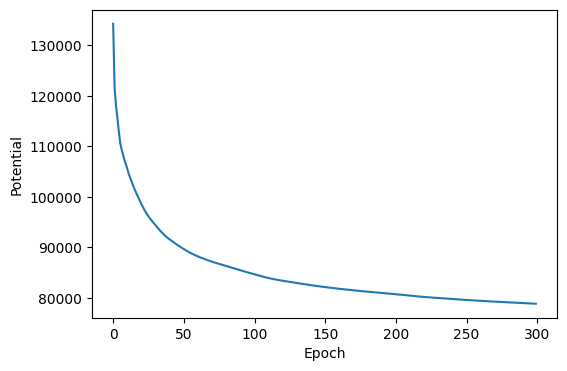

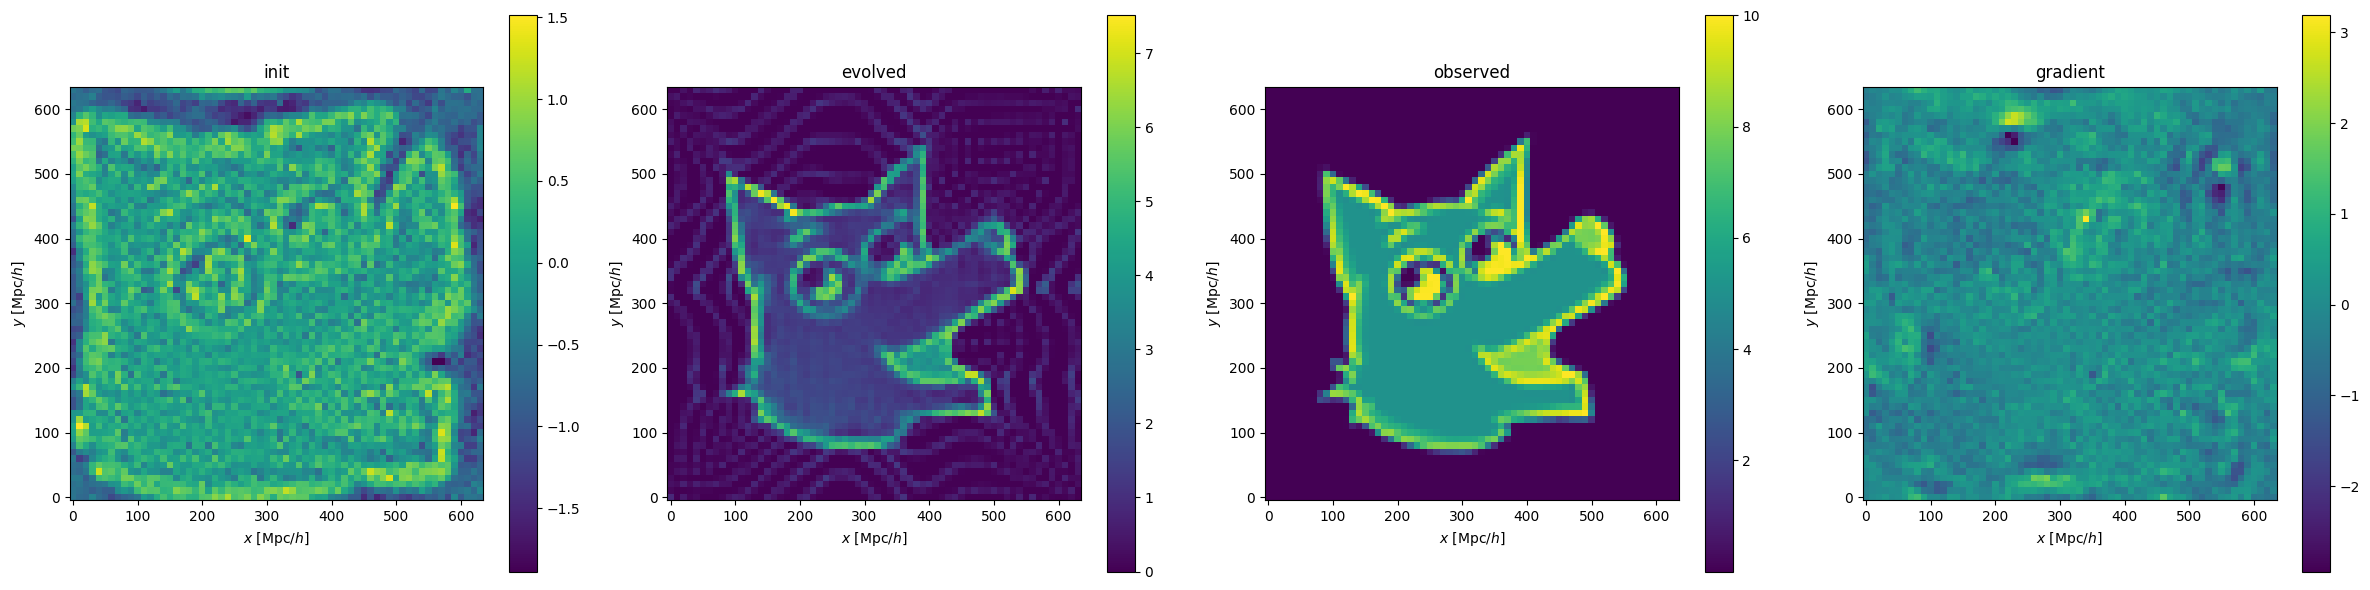

In [74]:
# @title Plot loss and final optimization state
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()
pm_mesh_mode = plot_optim_state(params)

## Posterior sampling

Actually, we are not interested solely in the posterior mode, but in the **full posterior distribution**. From it we can extract other relevant quantities such as the posterior mean, std, quantiles, or highest density regions (contours).

This time, the latent space is not 2 cosmological parameters but **a whole initial field**!

We can naively feed it directly to an efficient MCMC sampler and it would still produce posterior samples, but very slowly. This is due to:
1. High dimensional sampling implies more model evaluations per effective sample. Typically $n_{\text{eval}} \approx d^{1/4}$ for HMC, vs. $n_{\text{eval}} \approx d$ for MH.
2. Each model evaluation requires a N-body simulation, which is the computational bottleneck. Typically, time complexity of PM is in $O(d \log d)$.

We then expect something like a $d^{5/4} \log d$ growth.

**High-dimensional sampling is then a challenge for field-level inference**, which aims at infering cosmology and initial field from uncompressed observed field.

In [57]:
nuts_kernel = infer.NUTS(obs_model, max_tree_depth=5, init_strategy=infer.init_to_value(values=params),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=30, num_samples=150, num_chains=4, chain_method='vectorized')
mcmc.run(jr.key(43), extra_fields=['num_steps'])

samples, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("n_evals:", extra['num_steps'].sum())
# mcmc.print_summary()

sample: 100%|██████████| 180/180 [37:20<00:00, 12.44s/it]


total steps: 18600


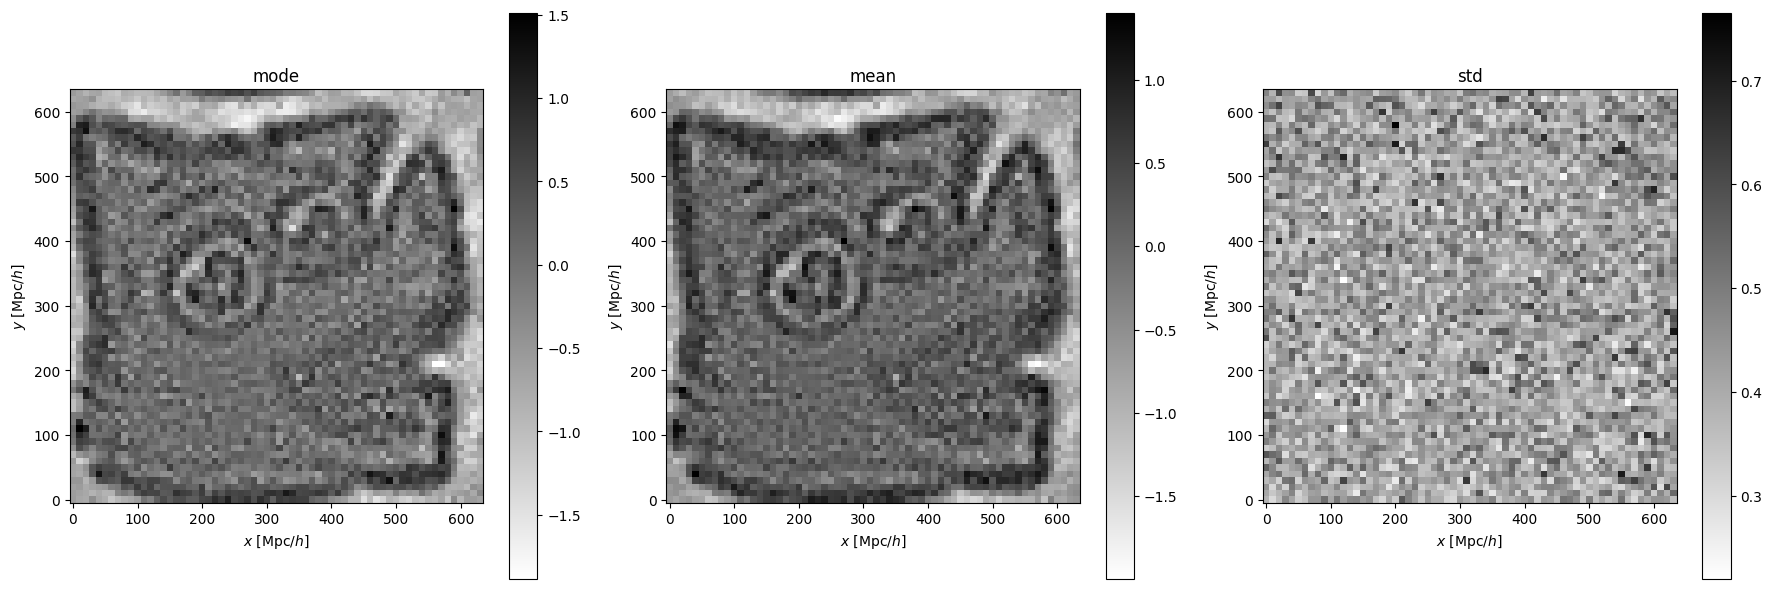

In [60]:
# @title Plot posterior
post_meshes = samples['init_mesh']
meshes = jnp.stack([params['init_mesh'], post_meshes.mean(0), post_meshes.std(0)])
titles = ['mode', 'mean', 'std']
animate_meshes(post_meshes[::10], **config)
plot_meshes(meshes, titles, **config)

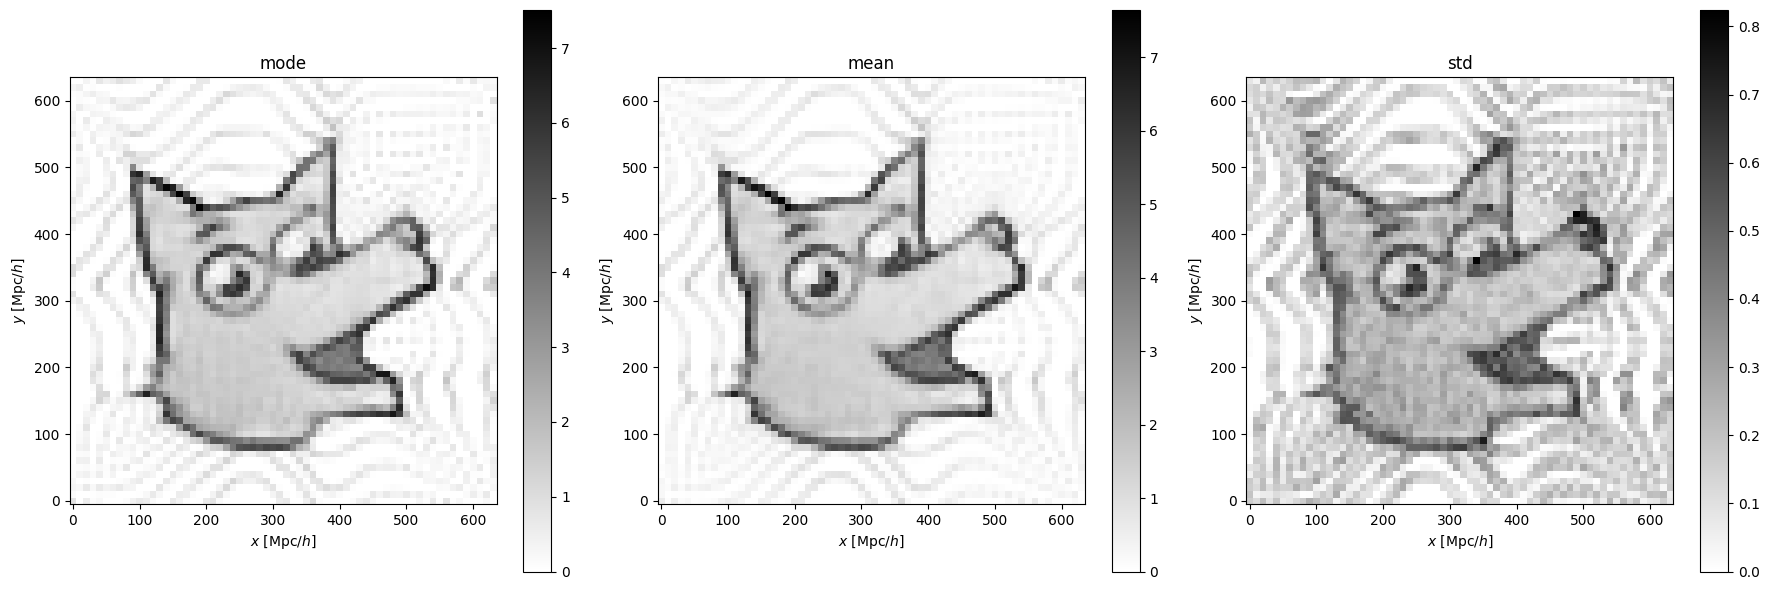

In [75]:
# @title Plot posterior predictive
post_meshes = samples['pm_mesh']
meshes = jnp.stack([pm_mesh_mode, post_meshes.mean(0), post_meshes.std(0)])
titles = ['mode', 'mean', 'std']
animate_meshes(post_meshes[::10], **config)
plot_meshes(meshes, titles, **config)